In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from html.parser import HTMLParser
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

from sklearn.metrics import classification_report

import time
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
stop_words = list(set(stopwords.words('english')))
punct = list(set(string.punctuation))
punct.append('“')
punct.append('”')
stemmer = PorterStemmer()

def text_cleaning(text):
    # converting HTML character codes to ASCII code
    parser = HTMLParser()
    text =  parser.unescape(text)
    
    text = re.sub(r'<[^>]+>','',text) # removing HTML tags
    text = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)','',text) # removing hash-tags
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+','',text) # removing URLs
    text = re.sub(r'(?:[\ufffd]+)','',text) #removing special characters
    text = word_tokenize(text)
    text = ' '.join(word for word in text if word not in punct) #remove punctuation
    text = re.sub('\n',' ',text) #remove new line
    text = re.sub('@','',text) #remove @ sign
    text = re.sub('\'','',text) # remove '
    text = text.lower() # lowercase all characters
    text = word_tokenize(text) # tonkenize words
    text = [i for i in text if not i in stop_words] #remove stop words
    #text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    
    return text


In [5]:
df_1 = pd.read_csv('/content/gdrive/My Drive/Amazon Seller Forum/amazon_scraped_data.csv') # raw data
df_2 = pd.read_csv('/content/gdrive/My Drive/Amazon Seller Forum/cleaned_data.csv',encoding= 'unicode_escape') # cleaned data
df_2.drop('Unnamed: 0',axis=1,inplace=True)
df_2['Title'].fillna('no title',inplace=True)

## Exploratory Analysis

Distribution of published post time


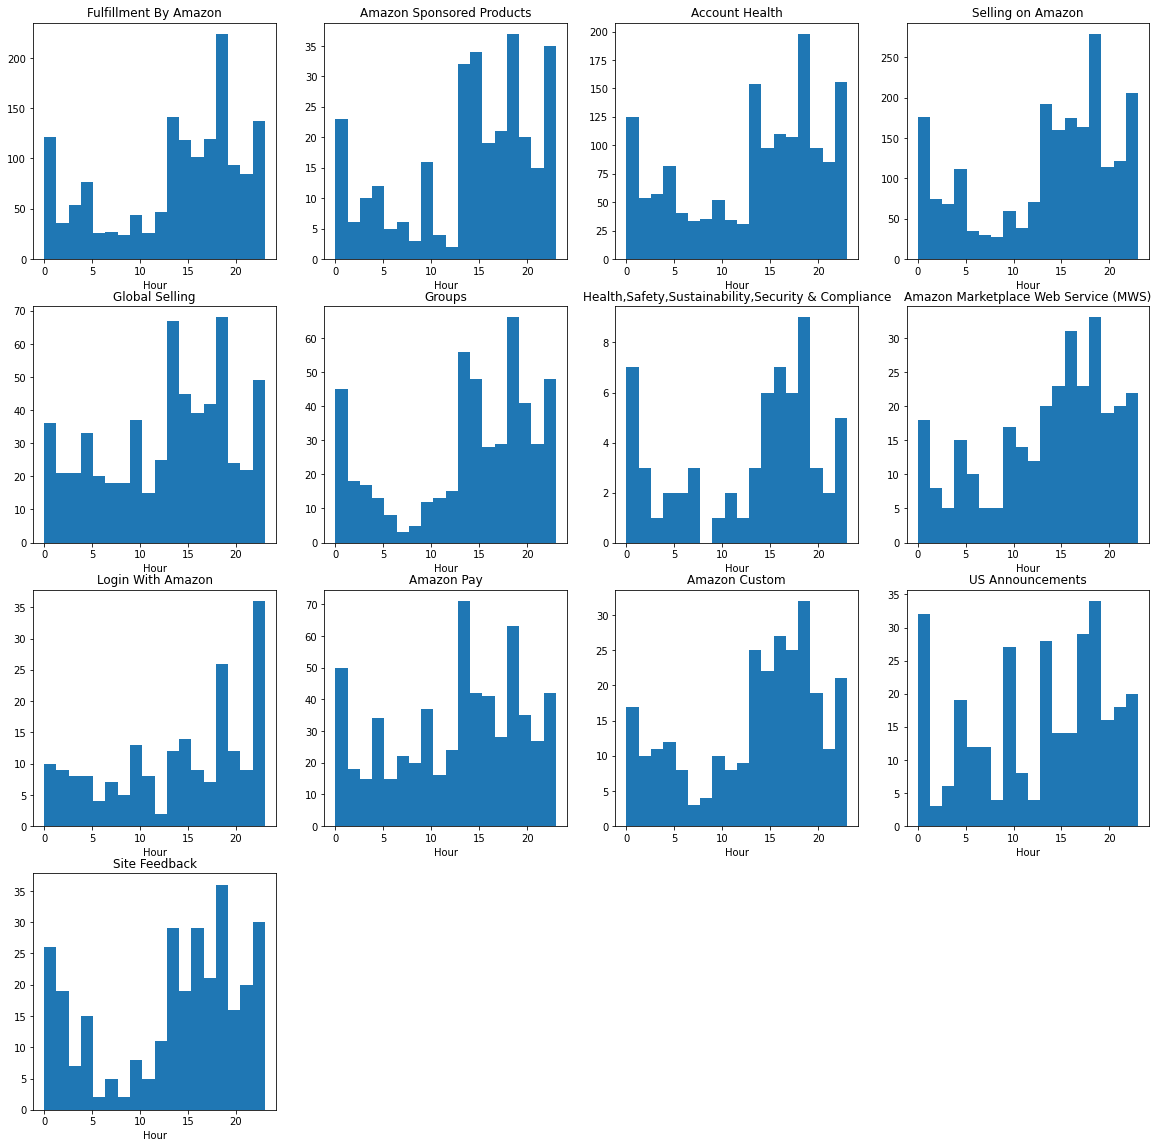

In [6]:
print('Distribution of published post time')
cat_list = df_2['Category'].unique()
num_cat = len(cat_list)

fig = plt.figure(figsize=(20,20))
for i in range(num_cat):
  ax = fig.add_subplot(4, 4, i+1)
  ax = plt.hist(df_2[df_2['Category'] == cat_list[i]]['Publish hour'],bins=18)
  plt.title(cat_list[i])
  plt.xlabel('Hour')

In [7]:
print('Users with most posts published')
pd.DataFrame(df_2.groupby('Post Author')['Title'].count().sort_values(ascending=False).head(10))

Users with most posts published


,Title
Post Author,
Amazon_News,213
Rick_MWS,52
SEAmod,24
Superior_Home_Busine,15
ChinaSupport,13
papyrophilia,13
austin_w_lwa,13
Chess,11
dzp1,11


In [8]:
print('Category with most posts published')
pd.DataFrame(df_2.groupby('Category')['Title'].count().sort_values(ascending=False))

Category with most posts published


,Title
Category,
Selling on Amazon,2099
Account Health,1548
Fulfillment By Amazon,1500
Global Selling,600
Amazon Pay,599
Groups,494
US Announcements,300
Site Feedback,300
Amazon Sponsored Products,300


In [16]:
for cat in df_2['Category'].unique():
  titles = df_2[df_2['Category']== cat]['Title']
  tfidf_vectorizer = TfidfVectorizer(max_df=0.5,
                                     max_features=20,
                                     stop_words='english',
                                     use_idf=True,
                                     ngram_range=(2,3))
  tfidf_matrix = tfidf_vectorizer.fit_transform(titles)
  terms = tfidf_vectorizer.get_feature_names()

  print('The top 5 key words in post title from the category: ', cat)
  print(terms[:5])
  print('\n')

The top 5 key words in post title from the category:  Fulfillment By Amazon
['amazon fba', 'channel fulfillment', 'fba inventory', 'fba order', 'fba returns']


The top 5 key words in post title from the category:  Amazon Sponsored Products
['ad campaign', 'ad campaigns', 'ad group', 'ad spend', 'amazon advertising']


The top 5 key words in post title from the category:  Account Health
['account deactivated', 'account risk', 'account suspended', 'account suspension', 'deactivated account']


The top 5 key words in post title from the category:  Selling on Amazon
['3rd party', 'account deactivated', 'amazon account', 'amazon seller', 'amazon seller app']


The top 5 key words in post title from the category:  Global Selling
['account suspended', 'amazon fba', 'amazon uk', 'amazon usa', 'bank account']


The top 5 key words in post title from the category:  Groups
['account suspended', 'amazon handmade', 'amazon home', 'amazon home services', 'cleaning jobs']


The top 5 key words in po

In [17]:
print('Top 10 authors with most amount of replys')
pd.DataFrame(df_2.groupby(['Category','Post Author'],
                          as_index=False)['num_Reply_Authors'].sum()).\
                          sort_values(by='num_Reply_Authors',ascending=False).head(10)

Top 10 authors with most amount of replys


,Category,Post Author,num_Reply_Authors
7354,US Announcements,Amazon_News,2413
4824,Groups,Superior_Home_Busine,109
7364,US Announcements,SEAmod,107
1156,Account Health,dzp1,67
4799,Groups,Real_Computers,66
7341,Site Feedback,papyrophilia,58
6820,Selling on Amazon,josephm,51
1512,Amazon Custom,bendztek,47
4725,Groups,John_C_Lipham_Constr,47
1762,Amazon Marketplace Web Service (MWS),The42ndStreet,46


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

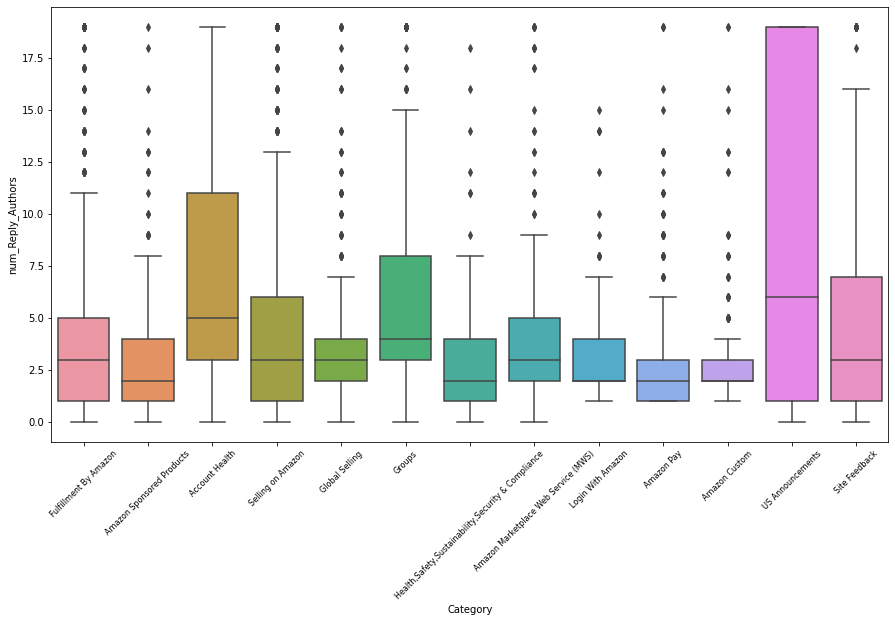

In [18]:
fig= plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax = sns.boxplot(x='Category',y='num_Reply_Authors',data=df_2)
plt.xticks(fontsize=8,rotation=45)

## Get similar comments based on cosine similarity method 

In [20]:
def get_top_comments(docu_list, n, labels):
    #Given a list of comments, find the indices with the highest n values.
    #Return the labels for each of these indices.
    return [labels[i] for i in np.argsort(docu_list)[::-1][:n]]  

### TFIDF

In [21]:
vectorizer = TfidfVectorizer(analyzer = 'word', 
                             stop_words = 'english', 
                             lowercase = True, 
                             max_features = 10000)

documents = df_2['Leading Comment']

documents_vec = vectorizer.fit_transform(documents).toarray()

words = vectorizer.get_feature_names()

random_comment = np.random.choice(documents, 1)

random_comment_vec = vectorizer.transform([random_comment[0]]).toarray()
# Calculate the similarity score(s) between vector(s) and training vectors
similarity_score = cosine_similarity(random_comment_vec, documents_vec)

# top 5 similar comments
# because the 1st comment is the randomly selected one, n should be set as n+1
n = 5+1
similar_comments = get_top_comments(similarity_score[0], n, list(documents))

print('The randomly selected comment: \n%s\n' % (random_comment[0]))
print('---Top %s similar comments---' % (n-1))
print('')

for i in range(1,n):
    print('No. %d similar comment is: \n %s.\n' % (i, similar_comments[i]))

The randomly selected comment: 
us based seller selling items amazonca via fba looking someone based ca accept returned items primarily sell home office type equipment touch handful liquidators based ca success arranging something thus far us sellers find canadian partner take returns would appreciate suggestions thanks

---Top 5 similar comments---

No. 1 similar comment is: 
 us looking expand selling canada shipping options usa ca saw looks like usp importing products ca shipping ca.

No. 2 similar comment is: 
 need liquidate inventory wanted see anyone success third party liquidators would appreciate info thanks.

No. 3 similar comment is: 
 fbm business based florida obviously costs ship parcel west coast ca wa wy etc northeast local states however im finding configure shipping zones increased rates based location set standard shipping cost matter customer fl way ca earth make sense way charge customer shipping price based shipping zone.

No. 4 similar comment is: 
 received infr

### Analysis with Count Vectorizer

In [ ]:
#First we initialize the count vectorizer
cvec = CountVectorizer(analyzer = 'word',
                       stop_words='english',
                       lowercase = True,
                       max_features = 5000)

documents = df['Leading Comment']

documents_vec = cvec.fit_transform(documents).toarray()

words = cvec.get_feature_names()

random_comment = np.random.choice(documents, 1)

random_comment_vec = vectorizer.transform([random_comment[0]]).toarray()

# Calculate the similarity score(s) between vector(s) and training vectors
similarity_score = cosine_similarity(random_comment_vec, documents_vec)

# top 5 similar comments
# because the 1st comment is the randomly selected one, n should be set as n+1
n = 5+1
similar_comments = get_top_comments(similarity_score[0], n, list(documents))

print('The randomly selected comment: \n%s\n' % (random_comment[0]))
print('---Top %s similar comments---' % (n-1))
print('')

for i in range(1,n):
    print('No. %d similar comment is: \n %s.\n' % (i, similar_comments[i]))




The randomly selected comment: 
applied bn already waiting confusion nri brokerage account ups fba seller want confirm medical equipment duty free

---Top 5 similar comments---

No. 1 similar comment is: 
 hello anyway link 2nd ups account sfp orders got new account ups allow ship certain items flat fee via ups 2nd day air country problem merge rates original ups account amazon giving option unlink existing account add new one.

No. 2 similar comment is: 
 account applied last never use want sell amazonbut account inactive account become inactive pls help thanks.

No. 3 similar comment is: 
 hi seller account suspended months money account amazon doesnt give money want close account get money repeatedly applied amazon help amazon communicating reactivate account want reactivate account want close seller account get money account please help thank.

No. 4 similar comment is: 
 purchased ups shipping amazon seller central ups lost package tried claim ups asking shipper account number cl

In [ ]:
for cat in df['Category'].unique():
  text = df[df['Category']== cat]['Title']
  count_vectorizer = CountVectorizer(analyzer = 'word',
                                     stop_words='english',
                                     min_df = 0.05
                                     )
  cvec_matrix = count_vectorizer.fit_transform(text)
  terms = count_vectorizer.get_feature_names()

  print('key words in post title from the category: ', cat)
  print(terms)
  print('\n')

key words in post title from the category:  Fulfillment By Amazon
['amazon', 'channel', 'fba', 'fulfillment', 'inventory', 'multi', 'order', 'product', 'report', 'shipment', 'shipping']


key words in post title from the category:  Selling on Amazon
['account', 'amazon', 'app', 'listing', 'product', 'seller', 'shipping']


key words in post title from the category:  Amazon Marketplace Web Service (MWS)
['access', 'amazon', 'api', 'developer', 'error', 'mws', 'order', 'orders', 'report']


key words in post title from the category:  Amazon Sponsored Products
['ad', 'ads', 'advertising', 'amazon', 'campaign', 'campaigns', 'keywords', 'ppc', 'product', 'products', 'search', 'sponsored']


key words in post title from the category:  Account Health
['account', 'amazon', 'appeal', 'complaint', 'deactivated', 'help', 'listing', 'new', 'poa', 'product', 'seller', 'sold', 'suspended', 'suspension', 'used']


key words in post title from the category:  Global Selling
['account', 'amazon', 'ca', 

## XGBoost

In [6]:
df_2['Leading Comment'] = df_2['Leading Comment'].apply(lambda x: word_tokenize(x))
df_2['Leading Comment'] = df_2['Leading Comment'].apply(lambda x: [stemmer.stem(word) for word in x])
df_2['Leading Comment'] = df_2['Leading Comment'].apply(lambda x: ' '.join(x))

df_2['Reply Comments'] = df_2['Reply Comments'].apply(lambda x: word_tokenize(x))
df_2['Reply Comments'] = df_2['Reply Comments'].apply(lambda x: [stemmer.stem(word) for word in x])
df_2['Reply Comments'] = df_2['Reply Comments'].apply(lambda x: ' '.join(x))

corpus = df_2['Leading Comment'] + df_2['Reply Comments']

Benchmark model (leading comment only, no resempling, no hyperparameter tuning)

In [24]:
vectorizer = TfidfVectorizer()

vectorized_matrix = vectorizer.fit_transform(df_2['Leading Comment'])

X = pd.DataFrame.sparse.from_spmatrix(vectorized_matrix,
                                      columns=vectorizer.get_feature_names())

y = df_2['Category']

# Split dataset into training and testing
X_train,X_test,y_train,y_test = train_test_split(X.values,y,
                                                 test_size=0.3,
                                                 random_state=123)
# Initiate model
clf = xgb.XGBClassifier(objective='multi:softmax')

start_time = time.time()

# Fit the model
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)

end_time = time.time()

run_time = end_time - start_time

# Display result
result = classification_report(y_test,y_pred)
print(result)

print('model run time: {} s'.format(np.round(run_time,2)))

                                                    precision    recall  f1-score   support

                                    Account Health       0.79      0.79      0.79       461
                                     Amazon Custom       0.49      0.25      0.33        73
              Amazon Marketplace Web Service (MWS)       0.68      0.67      0.67        88
                                        Amazon Pay       0.73      0.64      0.68       192
                         Amazon Sponsored Products       0.79      0.67      0.73        93
                             Fulfillment By Amazon       0.68      0.74      0.71       444
                                    Global Selling       0.49      0.19      0.27       179
                                            Groups       0.71      0.62      0.66       145
Health,Safety,Sustainability,Security & Compliance       0.00      0.00      0.00        18
                                 Login With Amazon       0.60      0.53      0.

model 1 (data resampling, leading comments only) 

In [25]:
rus = RandomUnderSampler()
X_resampled,y_resampled = rus.fit_resample(X,y)

X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,
                                                 test_size=0.3,
                                                 random_state=123)

clf = xgb.XGBClassifier(objective='multi:softmax')

start_time = time.time()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

end_time = time.time()

run_time = end_time - start_time

result = classification_report(y_test,y_pred)
print(result)

print('model run time: {} s'.format(np.round(run_time,2)))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                                                    precision    recall  f1-score   support

                                    Account Health       0.54      0.37      0.44        19
                                     Amazon Custom       0.44      0.61      0.51        18
              Amazon Marketplace Web Service (MWS)       0.78      0.69      0.73        26
                                        Amazon Pay       0.78      0.70      0.74        20
                         Amazon Sponsored Products       0.95      0.75      0.84        24
                             Fulfillment By Amazon       0.39      0.47      0.42        15
                                    Global Selling       0.25      0.33      0.29        12
                                            Groups       0.74      0.70      0.72        20
Health,Safety,Sustainability,Security & Compliance       0.47      0.56      0.51        16
                                 Login With Amazon       0.71      0.71      0.

model 2 (leading comments + reply, resampling)

In [8]:
vectorizer = TfidfVectorizer()

rus = RandomUnderSampler()


vectorized_matrix = vectorizer.fit_transform(corpus)

X = pd.DataFrame.sparse.from_spmatrix(vectorized_matrix,
                                      columns=vectorizer.get_feature_names())

y = df_2['Category']

X_resampled,y_resampled = rus.fit_resample(X,y)

X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,
                                                 test_size=0.3,
                                                 random_state=123)

clf = xgb.XGBClassifier(objective='multi:softmax')

start_time = time.time()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

end_time = time.time()

run_time = end_time - start_time

result = classification_report(y_test,y_pred)
print(result)

print('model run time: {} s'.format(np.round(run_time,2)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                                                    precision    recall  f1-score   support

                                    Account Health       0.74      0.74      0.74        19
                                     Amazon Custom       0.28      0.28      0.28        18
              Amazon Marketplace Web Service (MWS)       0.94      0.65      0.77        26
                                        Amazon Pay       0.71      0.60      0.65        20
                         Amazon Sponsored Products       0.95      0.88      0.91        24
                             Fulfillment By Amazon       0.40      0.40      0.40        15
                                    Global Selling       0.39      0.58      0.47        12
                                            Groups       0.88      0.70      0.78        20
Health,Safety,Sustainability,Security & Compliance       0.41      0.69      0.51        16
                                 Login With Amazon       0.71      0.57      0.